In [1]:
!pip install ta
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=2d1973071d2c2dae2e9c1832d9ab1fe429c838b7aa8670e4227f21f1067b9533
  Stored in directory: /root/.cache/pip/wheels/d7/4f/5c/9bfd8c96f1a36dccb743e81d8718ccde66454d9cda2427262e
Successfully built oandapyV20
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=37814c18eeea7d03c6d001101a238e09d6f5d7a182273e172f12156e7f944187
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from tqdm import tqdm
from arch import arch_model
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam



/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


open      0
high      0
low       0
close     0
volume    0
dtype: int64
              open         high          low        close         volume
count  2595.000000  2595.000000  2595.000000  2595.000000    2595.000000
mean      1.143632     1.147836     1.139476     1.143566   64436.474759
std       0.081528     0.081059     0.081778     0.081398   47778.772966
min       0.959070     0.967100     0.953600     0.959360       1.000000
25%       1.091610     1.096280     1.087490     1.091530   28281.000000
50%       1.126290     1.130980     1.121980     1.126320   52072.000000
75%       1.179625     1.183600     1.176240     1.179635   88088.000000
max       1.393420     1.399360     1.391010     1.393370  386009.000000


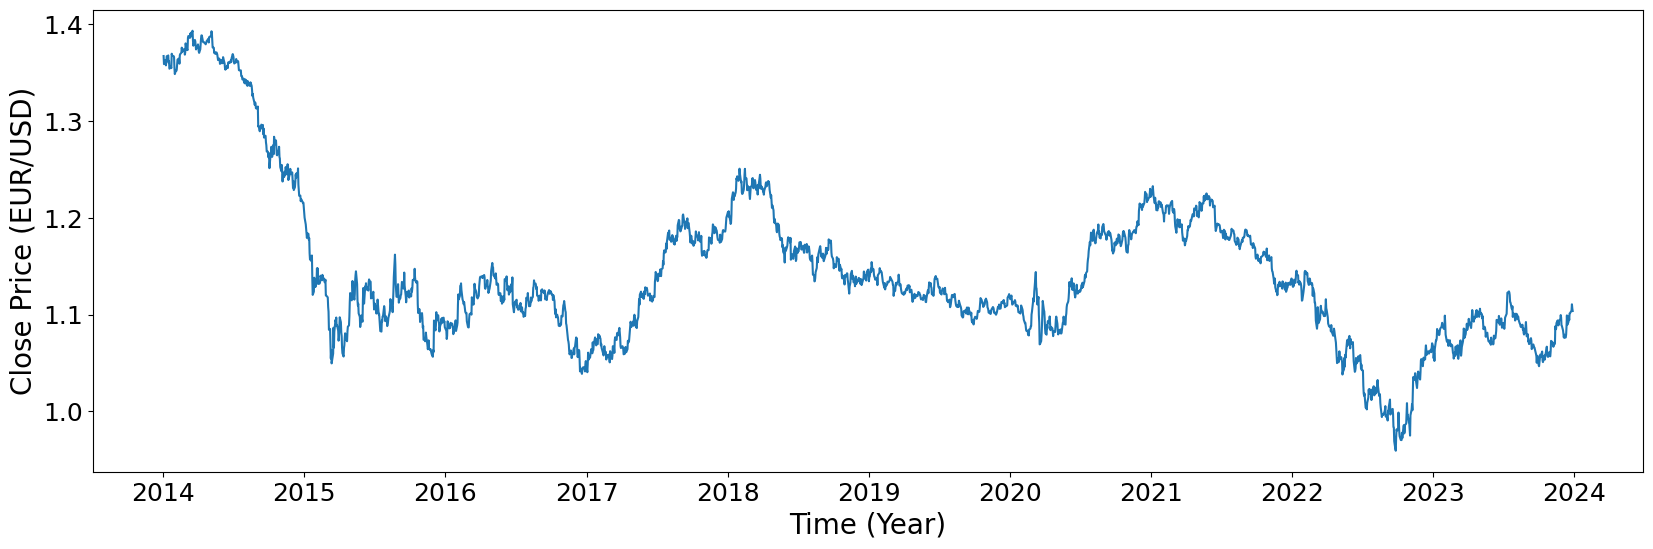

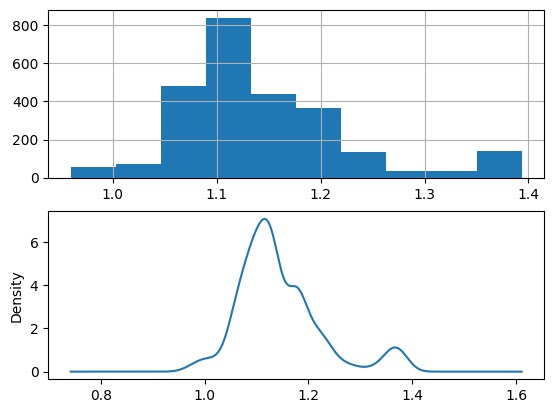

<ipython-input-6-dd8a5c04f982>:24: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  groups = df.close.groupby(pd.Grouper(freq='A'))


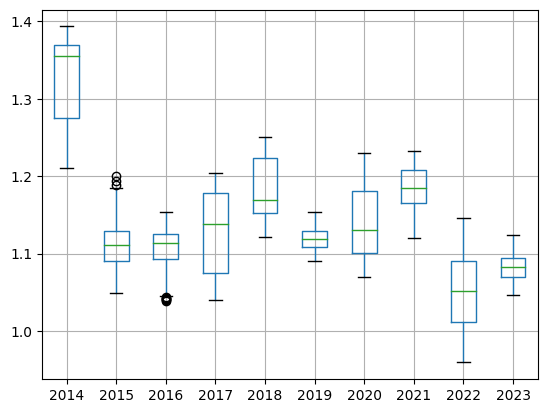

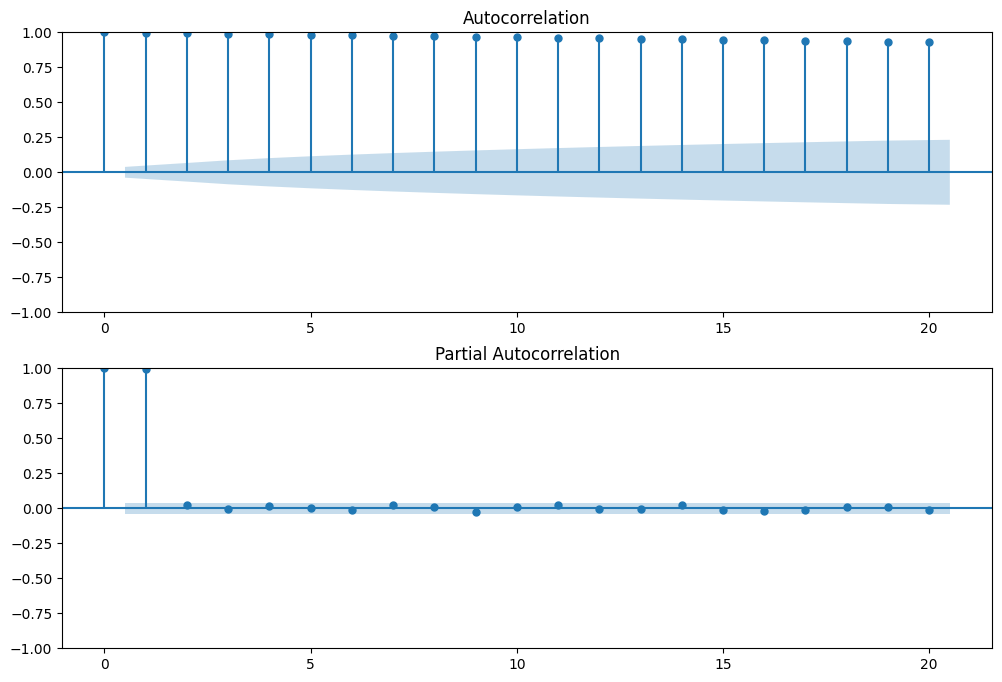

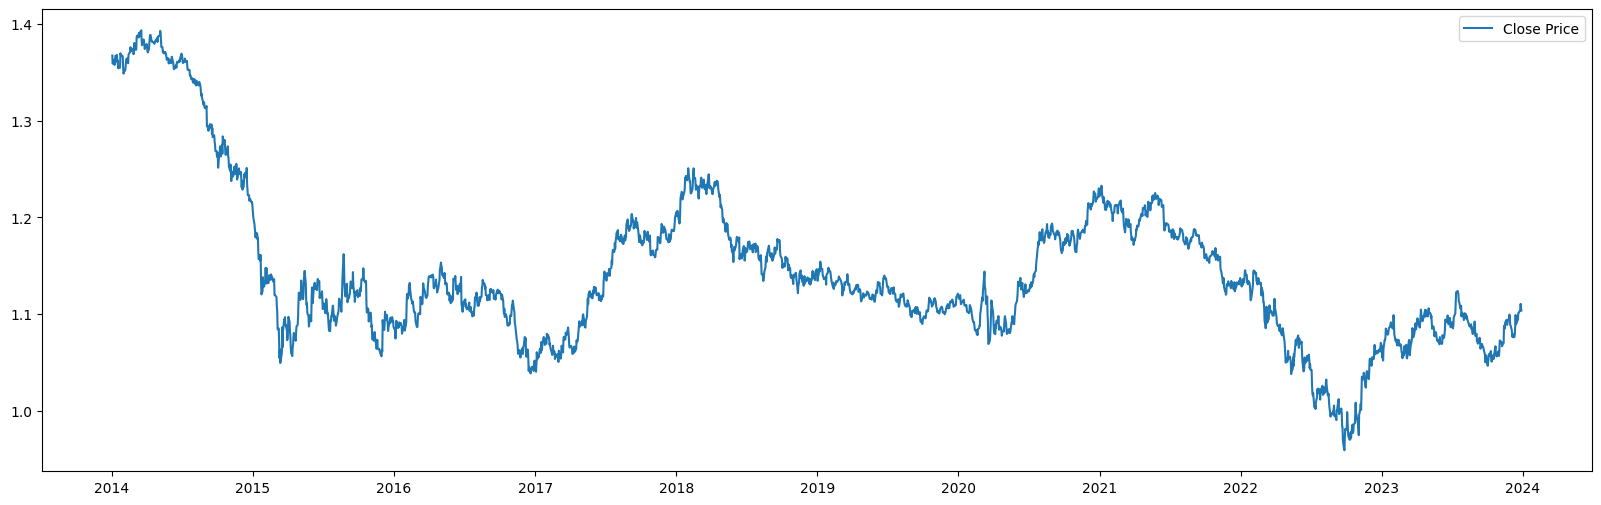

ADF Statistic: -2.666148
p-value: 0.080081
Critical Values:
   1%, -3.432886154825581
Critical Values:
   5%, -2.862660475187928
Critical Values:
   10%, -2.5673664697163323
ADF Statistic (differenced): -15.139609
p-value: 0.000000
Critical Values:
   1%, -3.432886154825581
Critical Values:
   5%, -2.862660475187928
Critical Values:
   10%, -2.5673664697163323


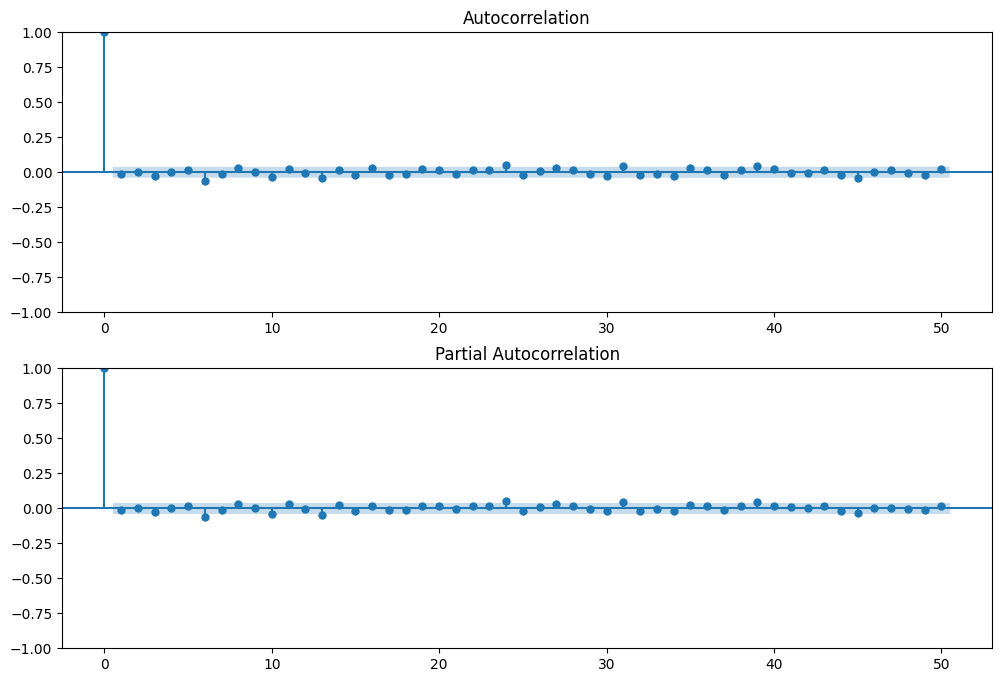

>Predicted=1.146, Expected=1.134
>Predicted=1.134, Expected=1.139
>Predicted=1.139, Expected=1.140
>Predicted=1.140, Expected=1.147
>Predicted=1.147, Expected=1.144
>Predicted=1.144, Expected=1.154
>Predicted=1.154, Expected=1.150
>Predicted=1.150, Expected=1.147
>Predicted=1.147, Expected=1.147
>Predicted=1.147, Expected=1.141
>Predicted=1.141, Expected=1.139
>Predicted=1.139, Expected=1.139
>Predicted=1.139, Expected=1.136
>Predicted=1.136, Expected=1.137
>Predicted=1.137, Expected=1.136
>Predicted=1.136, Expected=1.138
>Predicted=1.138, Expected=1.130
>Predicted=1.130, Expected=1.141
>Predicted=1.141, Expected=1.143
>Predicted=1.143, Expected=1.143
>Predicted=1.143, Expected=1.148
>Predicted=1.148, Expected=1.145
>Predicted=1.145, Expected=1.146
>Predicted=1.146, Expected=1.144
>Predicted=1.144, Expected=1.140
>Predicted=1.140, Expected=1.136
>Predicted=1.136, Expected=1.134
>Predicted=1.134, Expected=1.132
>Predicted=1.132, Expected=1.128
>Predicted=1.128, Expected=1.133
>Predicted

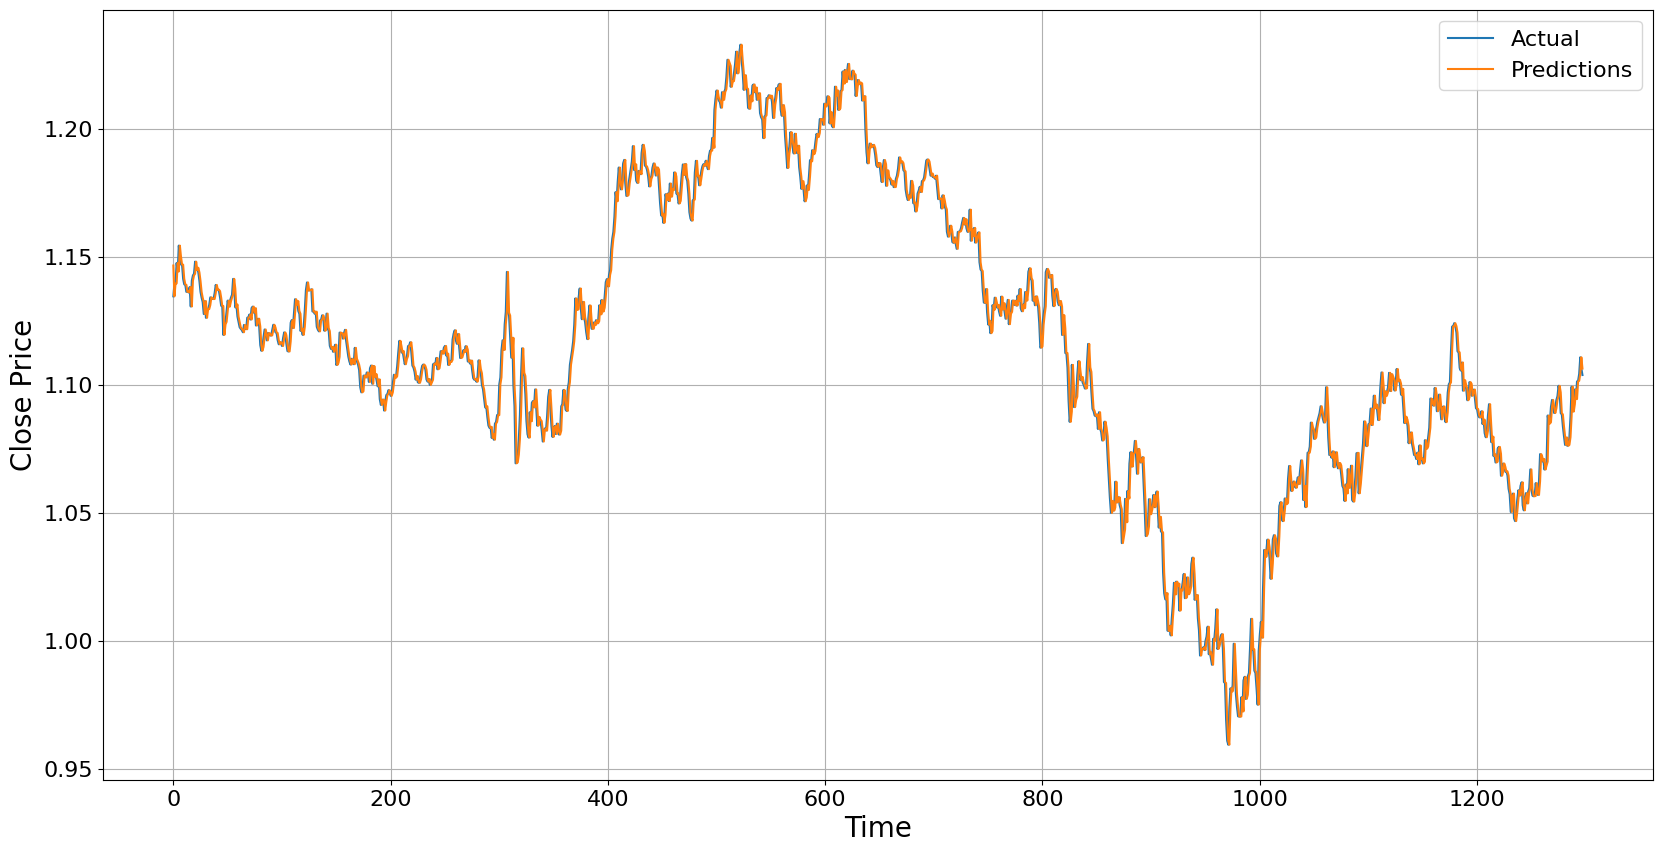

In [ ]:
#Load the data
df=pd.read_csv('forex_data.csv', index_col='time', parse_dates=True)
df.head()
print(df.isnull().sum())

#summary statistics
print(df.describe())

# Plot the close prices
plt.figure(figsize=(20, 6))
plt.plot(df['close'])
plt.xlabel('Time (Year)', fontsize=20)
plt.ylabel('Close Price (EUR/USD)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()
plt.figure(1)
plt.subplot(211)
df.close.hist()
plt.subplot(212)
df.close.plot(kind='kde')
plt.show()
# Create a boxplot for each year data
groups = df.close.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = pd.DataFrame(group.values)
years.boxplot()
plt.show()

# Plot ACF and PACF for the original series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['close'], lags=20, ax=ax[0])
plot_pacf(df['close'], lags=20, ax=ax[1])
plt.show()


# Load data
df = pd.read_csv('forex_data.csv', index_col='time', parse_dates=True)

# Plot the close prices
plt.figure(figsize=(20, 6))
plt.plot(df['close'], label='Close Price')
plt.legend()
plt.show()

# Check for stationarity using ADF test
result = adfuller(df['close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Apply first-order differencing
df['close_diff'] = df['close'].diff().dropna()

# Check for stationarity again using ADF test on differenced series
result = adfuller(df['close_diff'].dropna())
print('ADF Statistic (differenced): %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Plot ACF and PACF for the differenced series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['close_diff'].dropna(), lags=50, ax=ax[0])
plot_pacf(df['close_diff'].dropna(), lags=50, ax=ax[1])
plt.show()

# evaluate a persistence model
# prepare data
X = df.close.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # make prediction
  yhat = history[-1]
  predictions.append(yhat)
  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE: %.3f' % mae)
mape = mean_absolute_percentage_error(test, predictions)*100
print('MAPE: %.3f' % mape)

# plot the Naive predictions against the actual results
plt.figure(figsize=(20, 10))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predictions')
plt.legend(fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Close Price', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

